This lab session in an introduction to feed-forward neural network with pytorch. We use the dataset Fashion-MNIST (see for more details this website https://github.com/zalandoresearch/fashion-mnist). The dataset contains 60000 and 10000 images for respectively training and testing. Each image is 28x28 pixels, for a total of 784 per image.  An image is presented to the neural network as a flat vector of 784 component. 


In this lab session, you will experiment different kind of feed-forward networks, starting with simple models,  and then increasing their complexity. 

First load and test python and pytorch. Your notebook is supposed to work with python 3 (see the top right corner of the notebook).



In [1]:
import torch as th
print(th.__version__) # should be greater or equal to 1.0
import torch.nn as nn

import os

import numpy as np
import pickle
import math
import matplotlib
import matplotlib.pyplot as plt 

import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

%matplotlib inline
%config InlineBackend.figure_formats=['svg']
%config InlineBackend.figure_format = 'svg'

1.7.1


On a mis les fonctions utiles dans utils

In [21]:
os.chdir('C:\\Users\\sedra\\IDL\\PROJET METROPOLIS')
from utils import * # les fonctions utiles

# Dataset

Les données sont générées via l'algorithme XY_metropolis sur Matlab.

En sortie de Matlab : N cartes de spins (32x32) au format png, dans deux fichiers distincts selon la charge topologique totale (nulle : 'spin_first_0' ou non : 'spin_first_1').

Ces images sont collectées ici, transformées en numpy array puis en tenseur. 

In [2]:
allXtrain=[]
allYtrain=[]

os.chdir('C:\\Users\\sedra\\IDL\\PROJET METROPOLIS\\spin_first\\spin_first_0')

for i in range(1,8001):
    try :
        img = mpimg.imread('spin_{}.png'.format(i)) 
        allXtrain.append(img)
        allYtrain.append(0)
    except :
        print('spin_{} a une charge topo nulle malgré le crop'.format(i))
        
os.chdir('C:\\Users\\sedra\\IDL\\PROJET METROPOLIS\\spin_first\\spin_first_1')

for i in range(1,8001):
    try :
        img = mpimg.imread('spin_{}.png'.format(i)) 
        allXtrain.append(img)
        allYtrain.append(1)
    except :
        print('spin_{} a une charge topo nulle malgré le crop'.format(i))

spin_91 a une charge topo nulle malgré le crop
spin_283 a une charge topo nulle malgré le crop
spin_375 a une charge topo nulle malgré le crop
spin_501 a une charge topo nulle malgré le crop
spin_580 a une charge topo nulle malgré le crop
spin_587 a une charge topo nulle malgré le crop
spin_638 a une charge topo nulle malgré le crop
spin_639 a une charge topo nulle malgré le crop
spin_715 a une charge topo nulle malgré le crop
spin_749 a une charge topo nulle malgré le crop
spin_899 a une charge topo nulle malgré le crop
spin_1214 a une charge topo nulle malgré le crop
spin_1343 a une charge topo nulle malgré le crop
spin_1525 a une charge topo nulle malgré le crop
spin_1725 a une charge topo nulle malgré le crop
spin_1903 a une charge topo nulle malgré le crop
spin_2048 a une charge topo nulle malgré le crop
spin_2102 a une charge topo nulle malgré le crop
spin_2172 a une charge topo nulle malgré le crop
spin_2179 a une charge topo nulle malgré le crop
spin_2296 a une charge topo null

In [3]:
allXtrain_array=np.array(allXtrain)
allXtrain_array.shape
allXtrain_f=allXtrain_array.reshape(15923, 1, 32, 32)

Xtrain=th.cat([th.from_numpy(np.array(allXtrain_f[:7500,:,:,:])),th.from_numpy(np.array(allXtrain_f[8500:,:,:,:]))])
Ytrain=th.cat([th.from_numpy(np.array(allYtrain[:7500])),th.from_numpy(np.array(allYtrain[8500:]))])

Xvalid=th.from_numpy(np.array(allXtrain_f[7500:8500,:,:,:]))
Yvalid=th.from_numpy(np.array(allYtrain[7500:8500]))

Ytrain=Ytrain.long()
Yvalid=Yvalid.long()

In [20]:
Xtrain_lin=Xtrain.reshape(14923,1024)
Xvalid_lin=Xvalid.reshape(1000,1024)

In [21]:
Ztrain=Xtrain_lin
Zvalid=Xvalid_lin

In [73]:
Ztrain.shape

torch.Size([14923, 1024])

# 1. Classifieur linéaire


- a = w.*X* + w0 : un poids est associé à chaque pixel
- P(C=1|*X*) = sigma(a)
- Descente de gradient pour optimiser (w,w0)

In [57]:
def train(model, epochs=60,verbose=False):
    # The verbose allows you to skip printed information per epoch.
    # The function will only print the best accuracy on the validation
    # and plot the learning curves. 
    
    ### Mini-batching and shuffle 
    Ntrain = Ztrain.shape[0]
    Nvalid = Zvalid.shape[0]
    print(Ntrain,Nvalid)
    idx = np.arange(Ntrain)
    batch_size = 150 # Beaucoup plus rapide que 1 ! 
    nbatch = int(Ntrain/batch_size)
    print(batch_size, nbatch)


    train_losses,valid_losses, valid_accuracies=[],[],[]


    for e in range(epochs):
        np.random.shuffle(idx)
        running_loss=0
        totaln = 0
        for bi in range(nbatch): #on calcule la loss sur un gros paquet d'images !
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            images = Ztrain[ids]
            labels = Ytrain[ids]
            totaln += labels.shape[0] # the number of samples
            optimizer.zero_grad()
            logprobs=model(images)
            loss=loss_fn(logprobs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        # training is over for one epoch
        # now compute interesting quantities
        accuracy=0
        valid_loss = 0        
        with th.no_grad(): # On est plus entrain d'apprendre, plus de gradient
            model.eval()
            images = Zvalid
            labels = Yvalid
            logprobs=model(images)
            valid_loss=loss_fn(logprobs,labels)
            top_p,top_class=logprobs.topk(1)
            accuracy=(top_class.T == labels).sum().float()
        model.train()
        train_losses.append(running_loss/nbatch)
        valid_losses.append(valid_loss)
        valid_accuracies.append(accuracy.item()*100.0/Nvalid)
        '''
        print("Epoch: {}\t".format(e+1),
                  "train Loss: {:.5f}.. ".format(train_losses[-1]),
                  "valid Loss: {:.5f}.. ".format(valid_losses[-1]),
                  "valid Accuracy: {:.3f}".format(valid_accuracies[-1])) 
        '''
    print("---------- Best : {:.3f}".format(max(valid_accuracies)), " at epoch " 
          , np.fromiter(valid_accuracies, dtype=np.float).argmax(), " / ",epochs )
    
    plt.figure(figsize = (10, 2))
    ax= plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Train losses')
    ax.set_ylim(bottom=0)
    ax= plt.subplot(1, 3, 2)
    plt.plot(valid_losses)
    plt.title('Valid losses')
    ax.set_ylim(bottom=0)
    ax= plt.subplot(1, 3, 3)
    plt.plot(valid_accuracies)
    plt.title('Valid accuracies')
    ax.set_ylim(bottom=0)
    
    return


14923 1000
150 99
---------- Best : 59.600  at epoch  80  /  98


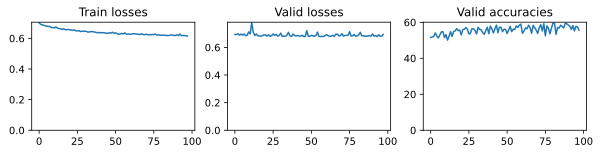

In [74]:
D_in=1024
D_out=2
# When we create the model, its parameters are initialized. 
model=nn.Sequential(
                    nn.Linear(D_in,D_out),
                    nn.LogSoftmax(dim=1))
optimizer=th.optim.Adam(model.parameters(),lr=0.001)
# Note this important to build a new optimizer 
# if we want to have the reference to parameters 
# of the new model ! 
train(model,98)

## 2. Un modèle plus complexe : une couche cachée

14923 1000
150 99
---------- Best : 58.900  at epoch  92  /  98


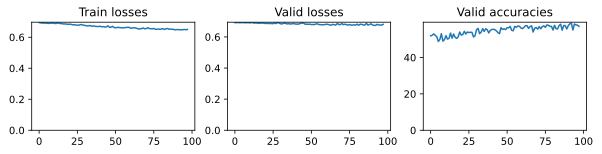

In [75]:
hidden_layer = 50
D_in = 1024 # image aplatie
D_out= 2 # 2 sorties : classification binaire

model_best = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.ReLU(),
    th.nn.Dropout(0.3),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model_best.parameters(),lr=0.001)

train(model_best,98)

Il semblerait qu'avec un dataset suffisament grand, et assez de paramètres sur la couche cachée (mais pas trop), on arrive à sortir des 50%.

# 3. Convolution

In [47]:
import torch as th
print(th.__version__) # should be greater or equal to 1.0
import torch.nn as nn

import os

import numpy as np
import pickle
import math
import matplotlib
import matplotlib.pyplot as plt 

import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

%matplotlib inline
%config InlineBackend.figure_formats=['svg']
%config InlineBackend.figure_format = 'svg'

1.7.1


In [48]:
allXtrain=[]
allYtrain=[]

os.chdir('C:\\Users\\sedra\\IDL\\PROJET METROPOLIS\\spin_first\\spin_first_0')

for i in range(1,8001):
    try :
        img = mpimg.imread('spin_{}.png'.format(i)) 
        allXtrain.append(img)
        allYtrain.append(0)
    except :
        print('spin_{} a une charge topo nulle malgré le crop'.format(i))
        
os.chdir('C:\\Users\\sedra\\IDL\\PROJET METROPOLIS\\spin_first\\spin_first_1')

for i in range(1,8001):
    try :
        img = mpimg.imread('spin_{}.png'.format(i)) 
        allXtrain.append(img)
        allYtrain.append(1)
    except :
        print('spin_{} a une charge topo nulle malgré le crop'.format(i))

spin_91 a une charge topo nulle malgré le crop
spin_283 a une charge topo nulle malgré le crop
spin_375 a une charge topo nulle malgré le crop
spin_501 a une charge topo nulle malgré le crop
spin_580 a une charge topo nulle malgré le crop
spin_587 a une charge topo nulle malgré le crop
spin_638 a une charge topo nulle malgré le crop
spin_639 a une charge topo nulle malgré le crop
spin_715 a une charge topo nulle malgré le crop
spin_749 a une charge topo nulle malgré le crop
spin_899 a une charge topo nulle malgré le crop
spin_1214 a une charge topo nulle malgré le crop
spin_1343 a une charge topo nulle malgré le crop
spin_1525 a une charge topo nulle malgré le crop
spin_1725 a une charge topo nulle malgré le crop
spin_1903 a une charge topo nulle malgré le crop
spin_2048 a une charge topo nulle malgré le crop
spin_2102 a une charge topo nulle malgré le crop
spin_2172 a une charge topo nulle malgré le crop
spin_2179 a une charge topo nulle malgré le crop
spin_2296 a une charge topo null

In [49]:
allXtrain_array=np.array(allXtrain)

In [61]:
allXtrain_array.shape

(15923, 32, 32)

In [60]:
allXtrain_f=allXtrain_array.reshape(15923, 1, 32, 32)

In [62]:
Xtrain=th.cat([th.from_numpy(np.array(allXtrain_f[:7500,:,:,:])),th.from_numpy(np.array(allXtrain_f[8500:,:,:,:]))])
Ytrain=th.cat([th.from_numpy(np.array(allYtrain[:7500])),th.from_numpy(np.array(allYtrain[8500:]))])

Xvalid=th.from_numpy(np.array(allXtrain_f[7500:8500,:,:,:]))
Yvalid=th.from_numpy(np.array(allYtrain[7500:8500]))

Ytrain=Ytrain.long()
Yvalid=Yvalid.long()

image.size() = [100, 1, 32, 32] = [batch_size, number of channels (3 si RGB), dim_X, dim_Y]

In [63]:
import torch.nn.functional as F

Penser au padding ! Meilleur estimation des bords ?

In [64]:
class Conv2d_classifier(nn.Module):   
    def __init__(self):
        super(Conv2d_classifier, self).__init__()
        self.conv1 = nn.Conv2d(1,8,5) # 1-grayscale ; 2-nbr sorties ; 3-kernel size
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(8*14*14,20) #conv1-pool-conv2-pool
        self.fc2 = nn.Linear(20,2) #2-classif binaire
        self.dropout = nn.Dropout(0.3) 

    # Defining the forward pass    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1,8*14*14) #-1- batch size #flatten it 
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        # softmax ? or is it in the loss
        return x

In [77]:
# How to get fc1 input dimension
conv1 = nn.Conv2d(1,8,5)
pool = nn.MaxPool2d(2,2)
conv2 = nn.Conv2d(3,6,5)

sortie=pool(F.relu(conv1(images)))

print(sortie.shape)

torch.Size([1000, 8, 14, 14])
torch.Size([1000, 8, 14, 14])


RuntimeError: shape '[-1, 150]' is invalid for input of size 1568000

In [65]:
classif = Conv2d_classifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(classif.parameters(), lr=0.001)

14923 1000
150 99
---------- Best : 88.100  at epoch  94  /  98


(0.0, 89.96)

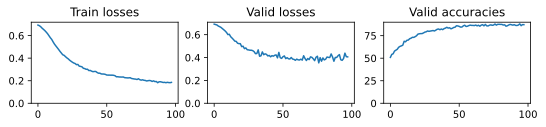

In [66]:
epochs = 98

Ntrain = Xtrain.shape[0]
Nvalid = Xvalid.shape[0]
print(Ntrain,Nvalid)
idx = np.arange(Ntrain)
batch_size = 150 # Beaucoup plus rapide que 1 ! 
nbatch = int(Ntrain/batch_size)
print(batch_size, nbatch)


train_losses,valid_losses, valid_accuracies=[],[],[]


for e in range(epochs):
    np.random.shuffle(idx)
    running_loss=0
    totaln = 0
    for bi in range(nbatch): #on calcule la loss sur un gros paquet d'images !
        ids = idx[bi*batch_size:(bi+1)*batch_size]
        images = Xtrain[ids]
        labels = Ytrain[ids]
        totaln += labels.shape[0] # the number of samples
        optimizer.zero_grad()
        logprobs=classif(images)
        loss=loss_fn(logprobs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    # training is over for one epoch
    # now compute interesting quantities
    accuracy=0
    valid_loss = 0        
    with th.no_grad(): # On est plus entrain d'apprendre, plus de gradient
        classif.eval()
        images = Xvalid
        labels = Yvalid
        logprobs=classif(images)
        valid_loss=loss_fn(logprobs,labels)
        top_p,top_class=logprobs.topk(1) #comment l'accuracy est elle calculé sur le set de valid ??
        accuracy=(top_class.T == labels).sum().float()
    classif.train()
    train_losses.append(running_loss/nbatch)
    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy.item()*100.0/Nvalid)
    '''
    print("Epoch: {}\t".format(e+1),
              "train Loss: {:.5f}.. ".format(train_losses[-1]),
              "valid Loss: {:.5f}.. ".format(valid_losses[-1]),
              "valid Accuracy: {:.3f}".format(valid_accuracies[-1])) 
    '''
print("---------- Best : {:.3f}".format(max(valid_accuracies)), " at epoch " 
      , np.fromiter(valid_accuracies, dtype=np.float).argmax(), " / ",epochs )

plt.figure(figsize = (9, 1.5))
ax= plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Train losses')
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 3, 2)
plt.plot(valid_losses)
plt.title('Valid losses')
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 3, 3)
plt.plot(valid_accuracies)
plt.title('Valid accuracies')
ax.set_ylim(bottom=0)
    

### dropout = 0.3 ; Conv2d(1,8,5) ; MaxPool(2,2) ; Linear(20,2) ; batch_size = 150

(0.0, 93.83)

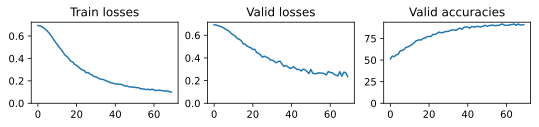

In [20]:
plt.figure(figsize = (9, 1.5))
ax= plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Train losses')
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 3, 2)
plt.plot(valid_losses)
plt.title('Valid losses')
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 3, 3)
plt.plot(valid_accuracies)
plt.title('Valid accuracies')
ax.set_ylim(bottom=0)

### without dropout : 

(0.0, 91.41)

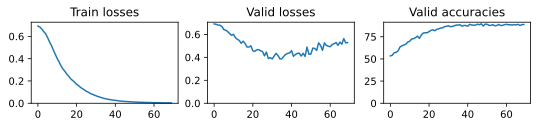

In [79]:
plt.figure(figsize = (9, 1.5))
ax= plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Train losses')
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 3, 2)
plt.plot(valid_losses)
plt.title('Valid losses')
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 3, 3)
plt.plot(valid_accuracies)
plt.title('Valid accuracies')
ax.set_ylim(bottom=0)

# 89.6 at epoch 47/70 : no dropout 

# Test

In [14]:
allXtest=[]
allYtest=[]

os.chdir('C:\\Users\\sedra\\IDL\\PROJET METROPOLIS\\spin_first\\test_set\\spin_0')

for i in range(1,21):
    try :
        img = mpimg.imread('spin_{}.png'.format(i)) 
        allXtest.append(img)
        allYtest.append(0)
    except :
        print('spin_{} a une charge topo nulle malgré le crop'.format(i))
        
os.chdir('C:\\Users\\sedra\\IDL\\PROJET METROPOLIS\\spin_first\\test_set\\spin_1')

for i in range(1,21):
    try :
        img = mpimg.imread('spin_{}.png'.format(i)) 
        allXtest.append(img)
        allYtest.append(1)
    except :
        print('spin_{} a une charge topo nulle malgré le crop'.format(i))

In [15]:
allXtest_array=np.array(allXtest)
allXtest_f=allXtest_array.reshape(40, 1, 32, 32)

Xtest=th.from_numpy(np.array(allXtest_f))
Ytest=th.from_numpy(np.array(allYtest))
Ytest=Ytest.long()

In [19]:
Ni=1
B=40
images=Xtest[Ni:Ni+B]
labels=Ytest[Ni:Ni+B]
classif.eval()

logprobs=classif(images)
valid_loss=loss_fn(logprobs,labels)
top_p,top_class=logprobs.topk(1) #top_p = valeur de l'élément le plus grand ; top_class = sa classe (son indice !)
accuracy=(top_class.T == labels).sum().float()

#print(top_class)
print(accuracy*100/B)

tensor(60.)


### Etude des convolutions 

In [ ]:
conv=conv1(images)
conv_img=conv.detach().numpy()

N=20
plt.figure(figsize = (15, 5))
plt.subplot(1,8,1)
plt.imshow(conv_img[N,1])
plt.subplot(1,8,2)
plt.imshow(conv_img[N,2])
plt.subplot(1,8,3)
plt.imshow(conv_img[N,3])
plt.subplot(1,8,4)
plt.imshow(conv_img[N,4])
plt.subplot(1,8,5)
plt.imshow(images[N,0])